# LR Analysis

This notebook analyze the LR properties of a system starting from the coupling matrix, transition quantities and the energies of the virtual orbitals

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import DoS as D
from futile import Yaml
from futile.Utils import write
import matplotlib.pyplot as plt
import numpy as np
import LRTDDFT as LR
HaeV=27.21138386

Autosave disabled


In [2]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'linear-response/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'linear-response/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../../

## Analysis of $CO$

In [3]:
norbCO = 5
pathCO = 'CO/free-bc/'
CO = build_syst_dict(pathCO, norbCO)
nalphaCO = [16,64,160,224]
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [4]:
reload(LR)
get_tddft_quantities(CO,pathCO)
LR.diagonalize_CM(norbCO,CO,nalphaCO)
LR.collect_LR(CO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY
Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 224
Eigensystem solved for 280
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 224
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 224
Eigensystem solved for 280


In [5]:
CO[7.0]['eigenproblems'][16].keys()

['eigenvectors',
 'alpha_xyz',
 'oscillator_strengths',
 'Cmat',
 'eigenvalues',
 'transitions',
 'oscillator_strength_avg']

### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [6]:
CO_alpha_ref = {'alphaX':13.235,'alphaY':13.235,'alphaZ':18.728}

In [7]:
reload(LR)
alpha_CO = LR.collect_Alpha(CO,norbCO)

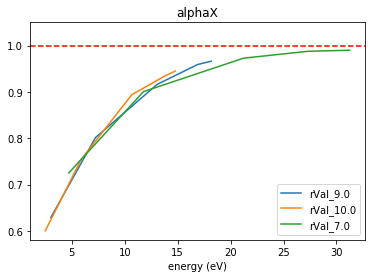

In [8]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_CO:
    val = np.array(alpha_CO[rVal][component])/CO_alpha_ref[component]
    plt.plot(alpha_CO[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [9]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

numpoint =  336  omegaMax (eV) =  45.8183849825
numpoint =  311  omegaMax (eV) =  42.431982253
numpoint =  434  omegaMax (eV) =  59.1066901023


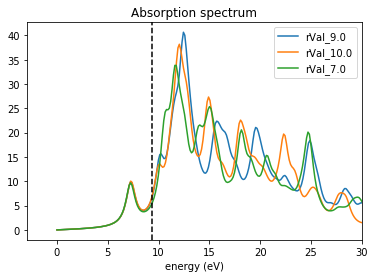

In [10]:
%matplotlib inline
syst = CO_spectrum
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We add the threshold key to the dictionary (for the first numExc excitations)

In [117]:
reload(LR)
numExc = 1000
LR.collect_excitation_thr(CO,norbCO,numExc,1e-2)

In [118]:
for rVal in CO:
    maxEng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][CO[rVal]['nvirt']]['eigenvalues'][numExc-1]) 
    print 'maxEng for rval_', rVal, ' = ', maxEng

maxEng for rval_ 9.0  =  22.3912346738
maxEng for rval_ 10.0  =  20.1359898379
maxEng for rval_ 7.0  =  29.0341031211


We plot the excitations landscape in the different box

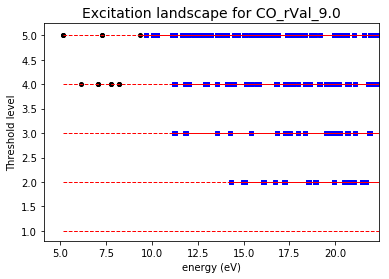

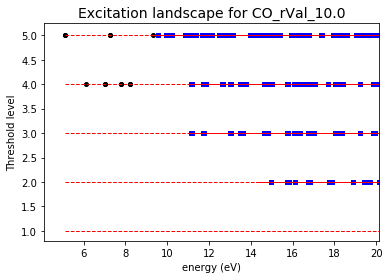

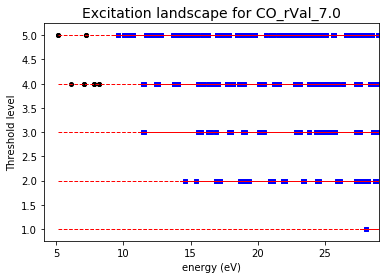

In [119]:
for rVal in CO:
    syst = CO[rVal]['eigenproblems'][CO[rVal]['nvirt']]
    pEng = LR.get_p_energy(CO[rVal]['logfile'],norbCO)

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])
    Emax = HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for ind,p in enumerate(pEng):
        plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
        plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
    for exc in range(numExc):
        eng = HaeV*np.sqrt(syst['eigenvalues'][exc])
        thind = syst['thresholds'][exc][0]
        th = HaeV*syst['thresholds'][exc][1]
        if eng < th : 
            plt.scatter(eng,thind,s=16,marker='o',c='black')
        else :
            plt.scatter(eng,thind,s=14,marker='s',c='blue')
    plt.title('Excitation landscape for CO_rVal_'+str(rVal),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.show()

We plot the dos (of a given channel) comparing the results of different box

In [120]:
reload(LR)
channels = LR.collect_channels(CO,norbCO,numExc)

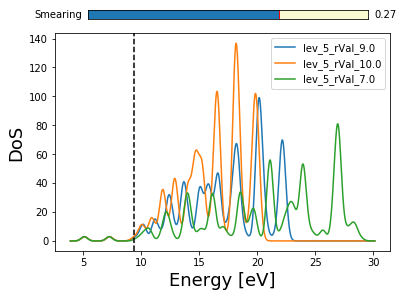

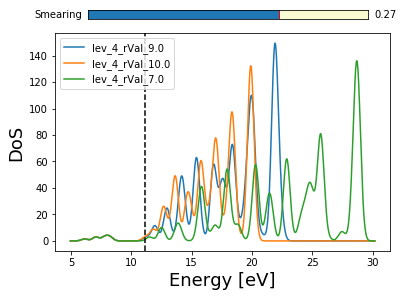

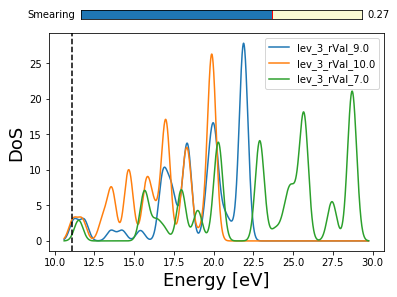

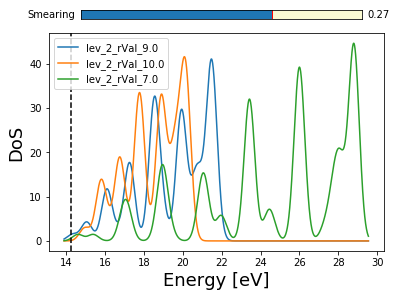

In [121]:
%matplotlib inline
levels = [5,4,3,2]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[l-1])
    dos=D.DoS(fermi_level=fe)
    for rVal in channels:
        dos.append(energies=np.array([channels[rVal][l-1]]),label='lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.01*HaeV)

These plots evidence the box independence of the excitations below threshold

As a final analysis we repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [122]:
reload(LR)
CO_spectrum_bt,CO_spectrum_at = LR.collect_spectrum_bt_at(CO)

numpoint =  164  omegaMax (eV) =  22.3912346738
numpoint =  164  omegaMax (eV) =  22.3912346738
numpoint =  147  omegaMax (eV) =  20.1359898379
numpoint =  147  omegaMax (eV) =  20.1359898379
numpoint =  213  omegaMax (eV) =  29.0341031211
numpoint =  213  omegaMax (eV) =  29.0341031211


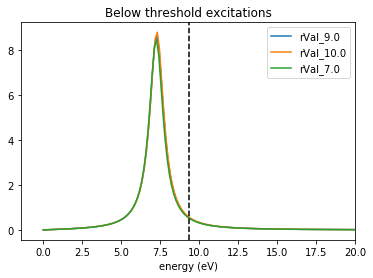

In [123]:
%matplotlib inline
syst = CO_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

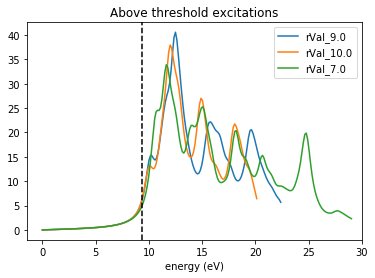

In [124]:
%matplotlib inline
syst = CO_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

## Analysis of $C_6H_6$

In [40]:
norbC6H6 = 15
pathC6H6 = 'C6H6/free-bc/'
C6H6 = build_syst_dict(pathC6H6, norbC6H6)
nalphaC6H6 = [16,64,160]
C6H6

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 220}, 9.0: {'nvirt': 220}, 10.0: {'nvirt': 220}}

In [41]:
reload(LR)
get_tddft_quantities(C6H6,pathC6H6)
LR.diagonalize_CM(norbC6H6,C6H6,nalphaC6H6)
LR.collect_LR(C6H6)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY
Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220


### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [42]:
C6H6_alpha_ref = {'alphaX':83.856,'alphaY':83.856,'alphaZ':45.62}

In [43]:
reload(LR)
alpha_C6H6 = LR.collect_Alpha(C6H6,norbC6H6)

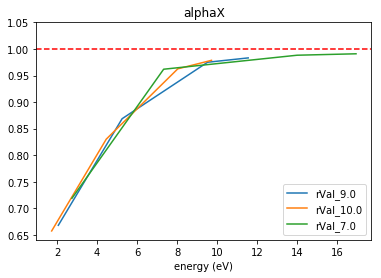

In [44]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_C6H6:
    val = np.array(alpha_C6H6[rVal][component])/C6H6_alpha_ref[component]
    plt.plot(alpha_C6H6[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [29]:
reload(LR)
C6H6_spectrum = LR.collect_spectrum(C6H6)

numpoint =  240  omegaMax (eV) =  32.740054836
numpoint =  228  omegaMax (eV) =  31.0830728297
numpoint =  280  omegaMax (eV) =  38.1274605755


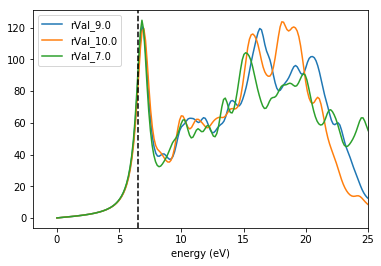

In [32]:
%matplotlib inline
syst = C6H6_spectrum
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=25)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We add the threshold key to the dictionary (for the first numExc excitations)

In [151]:
reload(LR)
numExc = 2000
LR.collect_excitation_thr(C6H6,norbC6H6,numExc,tol=2e-1)

In [152]:
for rVal in C6H6:
    maxEng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][C6H6[rVal]['nvirt']]['eigenvalues'][numExc-1]) 
    print 'maxEng for rval_', rVal, ' = ', maxEng

maxEng for rval_ 9.0  =  16.1237168597
maxEng for rval_ 10.0  =  15.0323595304
maxEng for rval_ 7.0  =  18.9331440236


We plot the excitations landscape in the different box

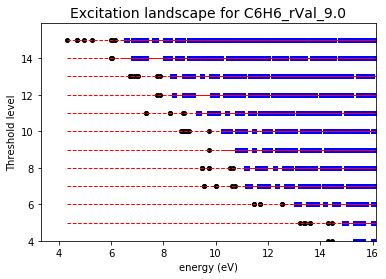

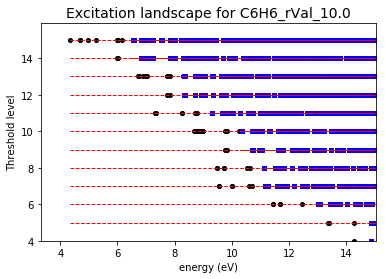

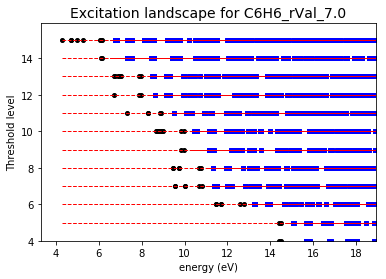

In [153]:
for rVal in C6H6:
    syst = C6H6[rVal]['eigenproblems'][C6H6[rVal]['nvirt']]
    pEng = LR.get_p_energy(C6H6[rVal]['logfile'],norbC6H6)

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])
    Emax = HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for ind,p in enumerate(pEng):
        plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
        plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
    for exc in range(numExc):
        eng = HaeV*np.sqrt(syst['eigenvalues'][exc])
        thind = syst['thresholds'][exc][0]
        th = HaeV*syst['thresholds'][exc][1]
        if eng < th : 
            plt.scatter(eng,thind,s=16,marker='o',c='black')
        else :
            plt.scatter(eng,thind,s=14,marker='s',c='blue')
    plt.title('Excitation landscape for C6H6_rVal_'+str(rVal),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.ylim(ymin=4)
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.show()

We plot the dos (of a given channel) comparing the results of different box

In [154]:
reload(LR)
channels = LR.collect_channels(C6H6,norbC6H6,numExc)

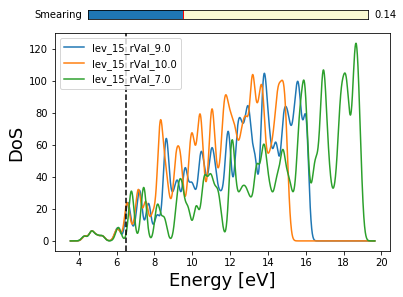

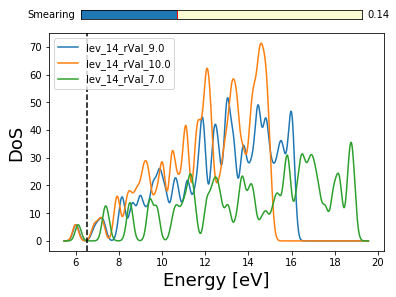

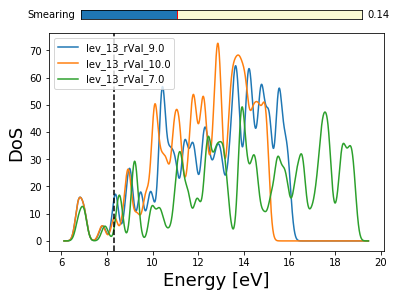

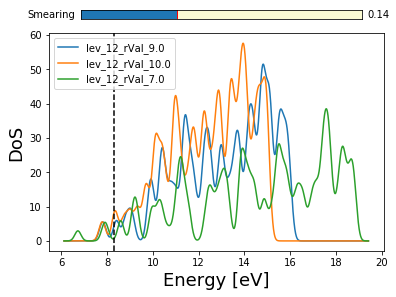

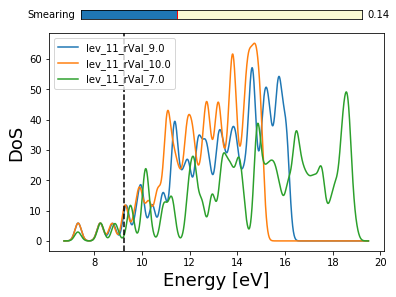

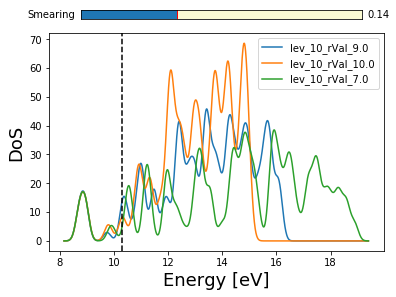

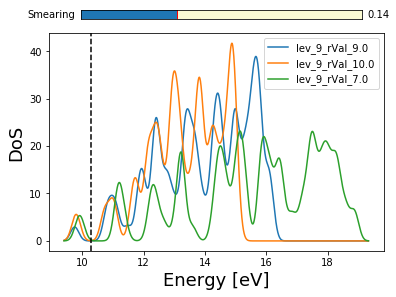

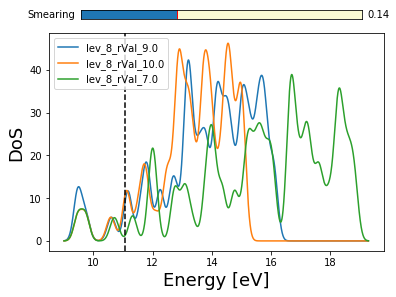

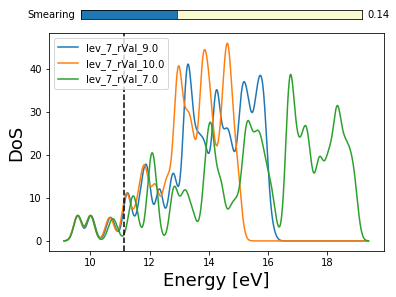

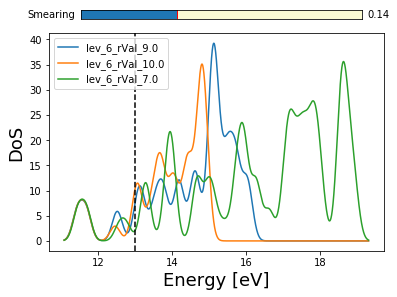

In [159]:
%matplotlib inline
levels = [15,14,13,12,11,10,9,8,7,6]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(C6H6[7.0]['logfile'],norbC6H6)[l-1])
    dos=D.DoS(fermi_level=fe)
    for rVal in channels:
        dos.append(energies=np.array([channels[rVal][l-1]]),label='lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.005*HaeV)

As a final analysis we repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [156]:
reload(LR)
C6H6_spectrum_bt,C6H6_spectrum_at = LR.collect_spectrum_bt_at(C6H6)

numpoint =  118  omegaMax (eV) =  16.1237168597
numpoint =  118  omegaMax (eV) =  16.1237168597
numpoint =  110  omegaMax (eV) =  15.0323595304
numpoint =  110  omegaMax (eV) =  15.0323595304
numpoint =  139  omegaMax (eV) =  18.9331440236
numpoint =  139  omegaMax (eV) =  18.9331440236


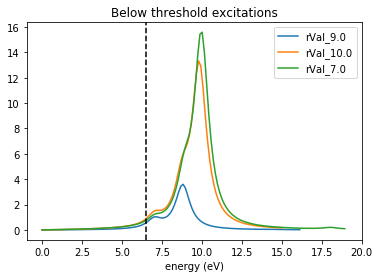

In [157]:
%matplotlib inline
syst = C6H6_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

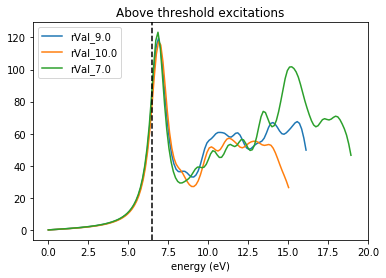

In [158]:
%matplotlib inline
syst = C6H6_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()